In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

# using Plots
using CairoMakie
using Random
using Printf
using DataFrames
using JLD
using StatsPlots
using LinearAlgebra
using NearestNeighbors
using DataInterpolations
using Clustering
using GraphMakie
using Graphs

example_networks = load(datadir("exp_pro/80-40-80_networks/examples.jld"))

df = collect_results(datadir("sims/repeated_evolution_different_topologies"));

df_current = filter(:n_traj=>x->x==2500,df);

evolutionary_runs = Dict{String,Any}("classical"=>df_current[:,"raw_data"][1],"feed_forward"=>df_current[:,"raw_data"][2],"mutual_inh"=>df_current[:,"raw_data"][3],"overlap_dom"=>df_current[:,"raw_data"][4]);

┌ Info: Scanning folder /Users/boothh/Documents/GRNEvoContingency/data/sims/repeated_evolution_different_topologies for result files.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:115
┌ Info: Added 13 entries.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:191


In [3]:
function select_marker(edge_value)
    edge_value > 0 ? :ltriangle : :vline
end

function draw_grn(network,color_scheme)

    weight_indices = Tuple.(findall(ones(size(network)) .> 0));

    adjacency_matrix = vcat(network,zeros(1,4))

    ng = SimpleDiGraph(adjacency_matrix)

    edge_indices = [(src(i),dst(i)) for i in edges(ng)]

    edge_values = [round(adjacency_matrix[id...],digits = 3) for id in edge_indices]

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    vertex_names = [vertex_names[i] for i in vertices(ng)]

    fixed_layout(_) = [(0.5, 1.), (0., 0), (1.,0),(0.5,2.)]

    offsets = [[0.02, 0.0],
                [-0.03, -0.05],
                [0.01, -0.05],
                [0.0, 0.01]]

    e_colors = [color_scheme[findall(x->x==t,weight_indices)[1]] for t in edge_indices]

    f, ax, p = graphplot(ng,layout = fixed_layout,node_color = :black,node_size = 30., elabels = string.(edge_values), nlabels = vertex_names,edge_color = e_colors,edge_width = 6.,arrow_size = 30.,arrow_shift = 0.1, arrow_attr = (; marker = [select_marker(edge_values[i]) for i in 1:ne(ng)]))

    p.elabels_rotation[] = Dict(i => edge_indices[i] == (1,4) ? 0.0 : Makie.automatic for i in 1:ne(ng))

    # offsets = 0.05 * (p[:node_pos][] .- p[:node_pos][][1])
    p.nlabels_offset[] = offsets

    autolimits!(ax)
    hidedecorations!(ax); hidespines!(ax)

    f,ax,p
end

function draw_grn!(ax,network,color_scheme)

    weight_indices = Tuple.(findall(ones(size(network)) .> 0));

    adjacency_matrix = vcat(network,zeros(1,4))

    ng = SimpleDiGraph(adjacency_matrix)

    edge_indices = [(src(i),dst(i)) for i in edges(ng)]

    edge_values = [round(adjacency_matrix[id...],digits = 3) for id in edge_indices]

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    vertex_names = [vertex_names[i] for i in vertices(ng)]

    fixed_layout(_) = [(0.5, 1.), (0., 0), (1.,0),(0.5,2.)]

    offsets = [[0.03, 0.0],
                [-0.06, -0.06],
                [0.03, -0.06],
                [0.03, -0.06]]

    e_colors = [color_scheme[findall(x->x==t,weight_indices)[1]] for t in edge_indices]

    graphplot!(ax,ng,layout = fixed_layout, node_color = :black, node_size = 30., elabels = string.(edge_values), nlabels = vertex_names,edge_color = e_colors,edge_width = 6.,arrow_size = 30.,arrow_shift = 0.1, arrow_attr = (; marker = [select_marker(edge_values[i]) for i in 1:ne(ng)]), elabels_rotation = Dict(i => edge_indices[i] == (1,4) ? 0.0 : Makie.automatic for i in 1:ne(ng)),nlabels_offset = offsets)

    autolimits!(ax)
    hidedecorations!(ax); hidespines!(ax)
end


function draw_grn_cn!(ax,network)

    weight_indices = Tuple.(findall(ones(size(network)) .> 0));

    adjacency_matrix = vcat(network,zeros(1,4))

    ng = SimpleDiGraph(adjacency_matrix)

    edge_indices = [(src(i),dst(i)) for i in edges(ng)]

    edge_values = [round(adjacency_matrix[id...],digits = 3) for id in edge_indices]

    vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

    vertex_names = [vertex_names[i] for i in vertices(ng)]

    fixed_layout(_) = [(0.5, 1.), (0., 0), (1.,0),(0.5,2.)]

    offsets = [[0.03, 0.0],
                [-0.06, -0.06],
                [0.03, -0.06],
                [0.03, -0.06]]

    graphplot!(ax,ng,layout = fixed_layout, node_color = [:red,:blue,:orange,:green], node_size = 40., elabels = string.(edge_values), elabels_align = (:right,:center),nlabels = vertex_names,edge_color = :black,edge_width = 6.,arrow_size = 30.,arrow_shift = 0.1, arrow_attr = (; marker = [select_marker(edge_values[i]) for i in 1:ne(ng)]),selfedge_size = 0.25, nlabels_offset = offsets, elabels_rotation = Dict(i => edge_indices[i] == (1,4) ? 0.0 : Makie.automatic for i in 1:ne(ng)))

    autolimits!(ax)
    hidedecorations!(ax); hidespines!(ax)
end

# [-0.01, 0.08]

draw_grn_cn! (generic function with 1 method)

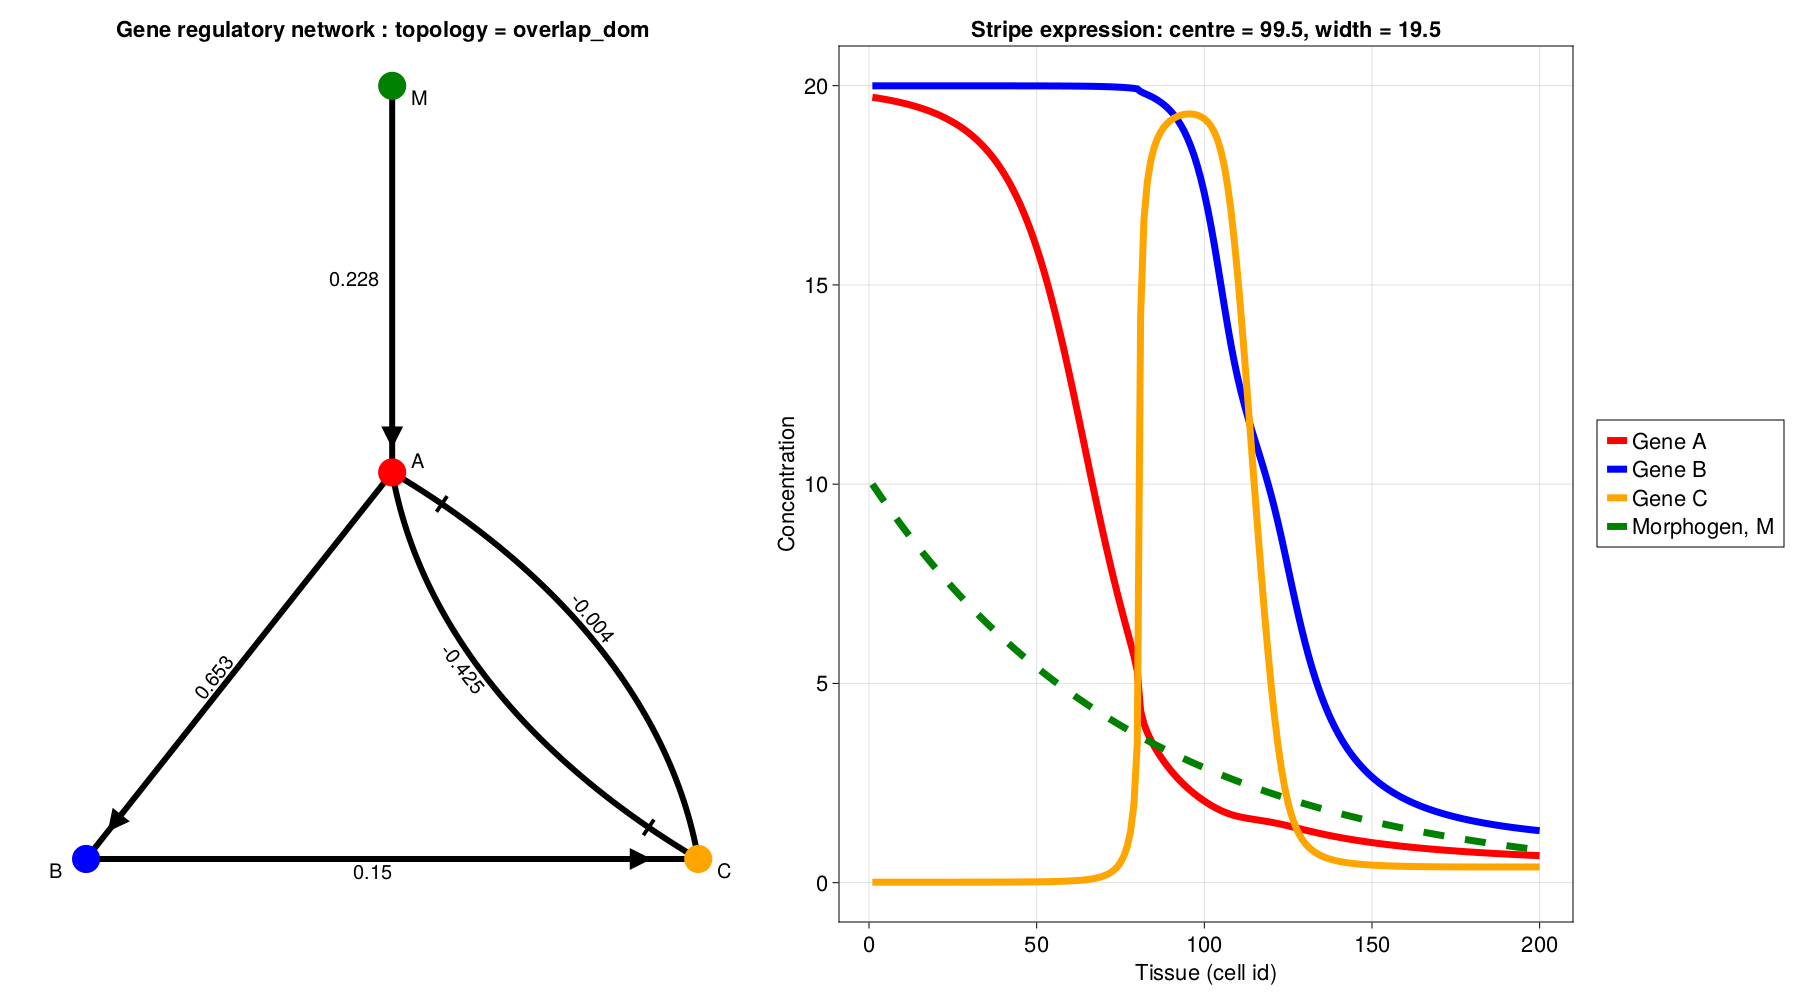

In [17]:
topology = "overlap_dom"

start_network = example_networks[topology]

run_data = evolutionary_runs[topology]

evo_traces = map(x->x[2],run_data);

pheno_traj = map(et->reduce(vcat,et.traversed_phenotypes),evo_traces)

initial_phenotype = pheno_traj[1][1]

grn_parameters = DefaultGRNParameters()

p = (start_network,grn_parameters.degradation)
    
grn = ODEProblem(gene_regulation_1d!,grn_parameters.g0,(0,Inf),p)

development = DefaultGRNSolver()

founder = Individual(grn,development);

fig = CairoMakie.Figure(resolution = (1800, 1000),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

line_colors = [:red,:blue,:orange,:green]

ax1  = Axis(fig[1,1], backgroundcolor = "white", title = "Gene regulatory network : topology = " * topology )

draw_grn_cn!(ax1,start_network)

ax2  = Axis(fig[1,2], backgroundcolor = "white", title = "Stripe expression: centre = " * string(initial_phenotype[1]) * ", width = " * string(initial_phenotype[2]),xlabel = "Tissue (cell id)", ylabel = "Concentration")

for i in 1:3
    lines!(ax2,founder.phenotype.u[end][i,:],label = "Gene " * vertex_names[i], color = line_colors[i],linewidth = 7.)
end

lines!(ax2,map(x->morph(x),tissue),label = "Morphogen, M",linewidth = 7.,linestyle = "--",color = :green)

leg = Legend(fig[1,3], ax2)

CairoMakie.save(plotsdir("Example networks",topology * "_network_example.png"),fig)

fig

In [13]:
geno_traj = map(et->et.traversed_topologies,evo_traces);

In [14]:
topology

"overlap_dom"

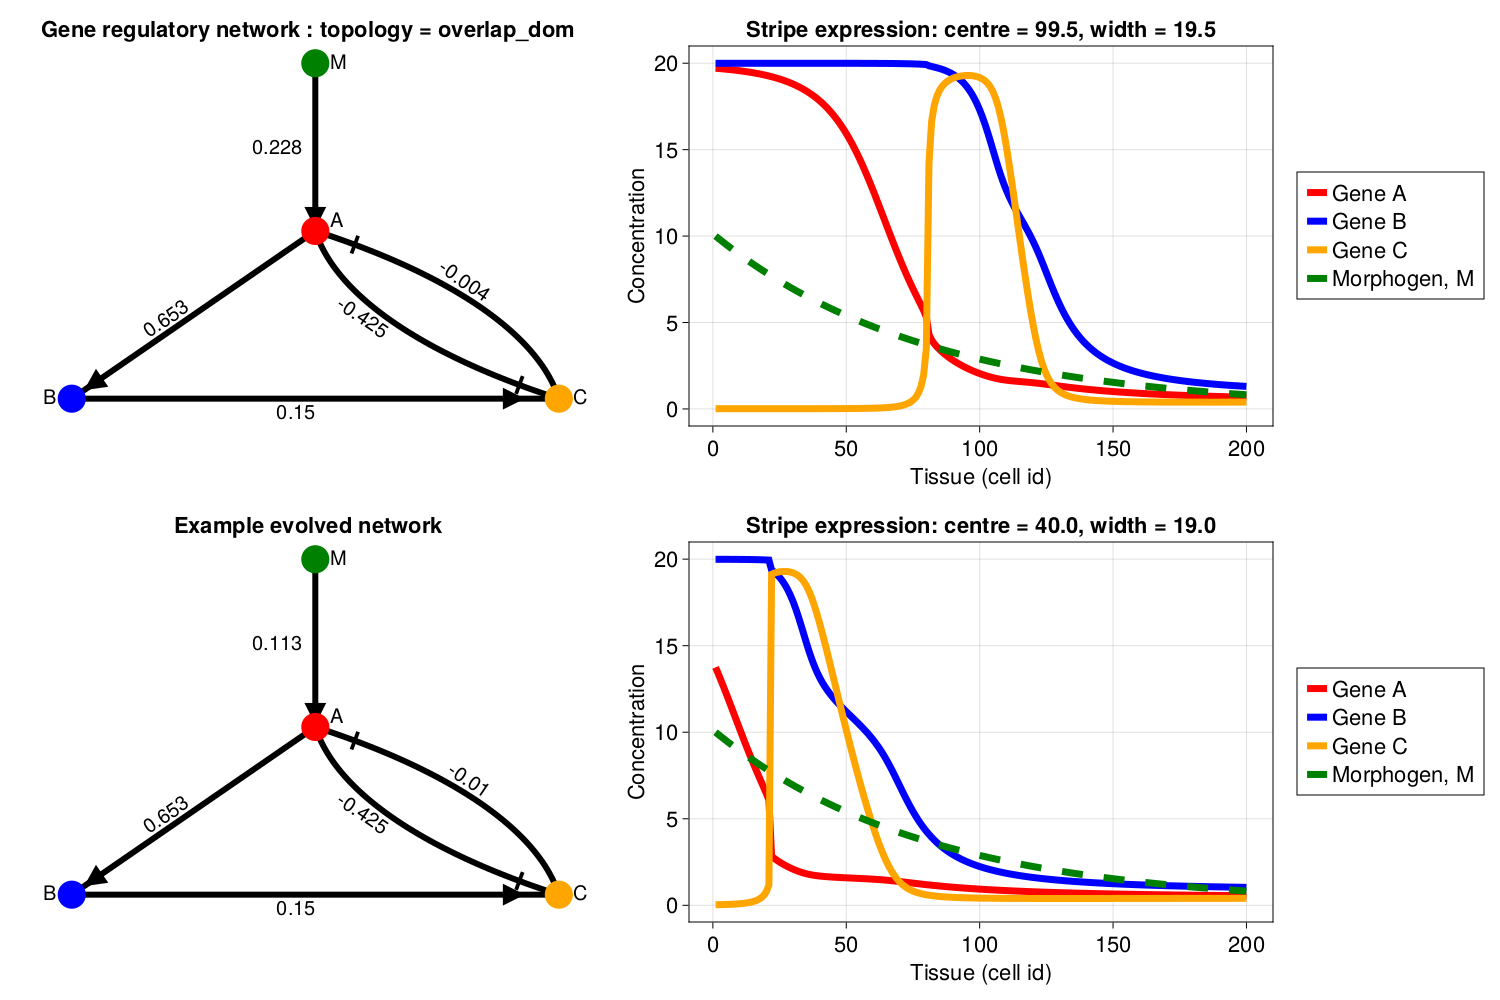

In [15]:
example_end = 1

start_network = example_networks[topology]

grn_parameters = DefaultGRNParameters()

p = (start_network,grn_parameters.degradation)
    
grn = ODEProblem(gene_regulation_1d!,grn_parameters.g0,(0,Inf),p)

development = DefaultGRNSolver()

founder = Individual(grn,development);

fig = CairoMakie.Figure(resolution = (1500, 1000),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

gt = fig[1,1]

ax1  = Axis(gt[1,1], backgroundcolor = "white", title = "Gene regulatory network : topology = " * topology )

draw_grn_cn!(ax1,start_network)

ax2  = Axis(gt[1,2], backgroundcolor = "white", title = "Stripe expression: centre = " * string(initial_phenotype[1]) * ", width = " * string(initial_phenotype[2]),xlabel = "Tissue (cell id)", ylabel = "Concentration")

for i in 1:3
    lines!(ax2,founder.phenotype.u[end][i,:],label = "Gene " * vertex_names[i], color = line_colors[i],linewidth = 7.)
end

lines!(ax2,map(x->morph(x),tissue),label = "Morphogen, M",linewidth = 7.,linestyle = "--",color = :green)

leg = Legend(gt[1,3], ax2)

############################

end_network =  geno_traj[example_end][end]

end_phenotype = pheno_traj[example_end][end]

p = (end_network,grn_parameters.degradation)
    
grn = ODEProblem(gene_regulation_1d!,grn_parameters.g0,(0,Inf),p)

development = DefaultGRNSolver()

founder = Individual(grn,development);

gb = fig[2,1]

ax1  = Axis(gb[1,1], backgroundcolor = "white", title = "Example evolved network")

draw_grn_cn!(ax1,end_network)

ax2  = Axis(gb[1,2], backgroundcolor = "white", title = "Stripe expression: centre = " * string(end_phenotype[1]) * ", width = " * string(end_phenotype[2]),xlabel = "Tissue (cell id)", ylabel = "Concentration")

for i in 1:3
    lines!(ax2,founder.phenotype.u[end][i,:],label = "Gene " * vertex_names[i], color = line_colors[i],linewidth = 7.)
end

lines!(ax2,map(x->morph(x),tissue),label = "Morphogen, M",linewidth = 7.,linestyle = "--",color = :green)

leg = Legend(gb[1,3], ax2)

CairoMakie.save(plotsdir("Example evolved networks",topology * "_network_example.png"),fig)

fig

In [16]:
start_network = example_networks[topology]

run_data = evolutionary_runs[topology]

evo_traces = map(x->x[2],run_data);

pheno_traj = map(et->reduce(vcat,et.traversed_phenotypes),evo_traces)

initial_phenotype = pheno_traj[1][1]

grn_parameters = DefaultGRNParameters()

p = (start_network,grn_parameters.degradation)
    
grn = ODEProblem(gene_regulation_1d!,grn_parameters.g0,(0,Inf),p)

development = DefaultGRNSolver();

founder = Individual(grn,development);

max_conc = round(1.05*maximum(reduce(vcat,founder.phenotype.u)),digits = 0)

ss_tend = round(founder.phenotype.t[end],digits = 0)

tspan = (0,ss_tend)

sol_ode = solve(grn,Tsit5(), isoutofdomain=(u,p,t) -> any(x -> x < 0, u), reltol = 1e-6,abstol = 1e-8,callback = TerminateSteadyState(1e-10,1e-6),maxiters = 1e4, verbose = false,saveat = 1:1:ss_tend);

fig = CairoMakie.Figure(resolution = (1500, 1000),fontsize = 22.)

color_scheme = palette(:tab10)

weight_indices = Tuple.(findall(ones(3,4) .> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

gt = fig[1,1]

ax1  = Axis(gt[1,1], backgroundcolor = "white", title = "Gene regulatory network : topology = " * topology )

draw_grn_cn!(ax1,start_network)

ax2  = Axis(gt[1,2], backgroundcolor = "white", title = "Stripe expression: centre = " * string(initial_phenotype[1]) * ", width = " * string(initial_phenotype[2]),xlabel = "Tissue (cell id)", ylabel = "Concentration")

line_history = []

for i in 1:3
    l_new = lines!(ax2,sol_ode.u[1][i,:],label = "Gene " * vertex_names[i], color = line_colors[i],linewidth = 7.)
    push!(line_history,l_new)
end

m_line = lines!(ax2,map(x->morph(x),tissue),label = "Morphogen, M",linewidth = 7.,linestyle = "--",color = :green)

CairoMakie.ylims!(ax2, 0.,max_conc)
CairoMakie.xlims!(ax2, 0.,200)

leg = Legend(gt[1,3], ax2)

for ls in line_history
    delete!(ax2,ls)
end

delete!(ax2,m_line)

record(fig, plotsdir("Animations",topology * "_example_network_anim.gif")) do io
    for t = 1:ss_tend

        line_history = []

        for i in 1:3
            l_new = lines!(ax2,sol_ode.u[Int64(t)][i,:],label = "Gene " * vertex_names[i], color = line_colors[i],linewidth = 7.)
            push!(line_history,l_new)
        end
        
        m_line = lines!(ax2,map(x->morph(x),tissue),label = "Morphogen, M",linewidth = 7.,linestyle = "--",color = :green)

        recordframe!(io) # record a new frame

        for ls in line_history
            delete!(ax2,ls)
        end

        delete!(ax2,m_line)
    end
end

"/Users/boothh/Documents/GRNEvoContingency/plots/Animations/overlap_dom_example_network_anim.gif"